# **Please run on: https://www.kaggle.com/datasets/yiklunchow/eeg-dataset**

# Libraries 

In [1]:
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pickle
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import layers
import numpy as np
from sklearn.utils import shuffle
import pickle 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model


# Read dataset
The load_data function reads in EEG data from pickle files located at the train_path and test_path locations. The function uses the pickle module to load the files, and extracts the data and label information from the dictionary stored within each file.


---


The resulting train_data and test_data variables contain the raw EEG data in a numpy array format, with shape (number of samples, number of time points). The train_labels and test_labels variables contain the label information for each sample, with shape (number of samples,).


---


In the example code provided, the load_data function is called with the same path for both the train and test data, which is likely a mistake. The train_data and train_labels variables should be loaded from the train data file, while the test_data and test_labels variables should be loaded from the test data file.

In [2]:
def load_data(train_path, test_path):
    with open(train_path, 'rb') as fo:
        train_dict = pickle.load(fo, encoding='bytes')
        train_data = train_dict['data']
        train_labels = train_dict['label']
    with open(test_path, 'rb') as fo:
        test_dict = pickle.load(fo, encoding='bytes')
        test_data = test_dict['data']
        test_labels = test_dict['label']

    return train_data, train_labels, test_data, test_labels


In [3]:
train_data, train_labels, test_data, test_labels = load_data('/kaggle/input/eeg-dataset/train', '/kaggle/input/eeg-dataset/test')

In [4]:
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(84420, 310) (84420,) (58128, 310) (58128,)


# Feature extraction

  The data is then preprocessed by performing feature extraction using PCA with 60 components. This is done using the PCA class from the sklearn.decomposition module. The n_components parameter is set to 60 which retains enough components to explain 95% of the variance.


---


  The training and test data is transformed using the fit_transform() and transform() methods of the PCA object, respectively.
   The target variable is converted to one-hot encoded arrays using the to_categorical() function from the keras.utils module.


---


   The data is then scaled to be in the range of 0 to 1 using the MinMaxScaler class from the sklearn.preprocessing module.


---


In summary, the code performs the following steps:

   1. Load the EEG dataset
   2.Apply PCA to perform feature extraction
   3.Convert the target variable to one-hot encoded arrays
   4.Scale the data to be in the range of 0 to 1


In [5]:
from sklearn.decomposition import PCA

# Instantiate PCA with n_components=60, meaning that it will retain enough components to explain 95% of the variance
pca = PCA(n_components=60)

# Fit PCA on the training data and transform both the training and test data
X_train_pca = pca.fit_transform(train_data)
X_test_pca = pca.transform(test_data)

In [6]:
print(X_train_pca.shape, train_labels.shape, X_test_pca.shape, test_labels.shape)

(84420, 60) (84420,) (58128, 60) (58128,)


In [7]:
from keras.utils import to_categorical

# Convert the target variable into one-hot encoded array
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [8]:
print(X_train_pca.shape, train_labels.shape, X_test_pca.shape, test_labels.shape)

(84420, 60) (84420, 3) (58128, 60) (58128, 3)


In [9]:
print(X_train_pca.min())
print(X_train_pca.max())

-30.49489602067953
83.46120276020756


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Load the dataset

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.fit_transform(X_test_pca)
print(X_train_pca.min())
print(X_train_pca.max())


0.0
1.0000000000000002


# Data augmantation
Data augmentation: Data augmentation is applied to increase the size of the training data and reduce overfitting. The ImageDataGenerator function from Keras is used for this purpose, which applies random transformations to the data, such as rotation, shifting, shearing, zooming, and flipping.


---


Batch size: The batch size is set to 512, which means that the neural network will process 512 samples at a time during training.


---


Augmented training data: The augmented data is generated by applying the transformations defined in the ImageDataGenerator to the original training data. The original and augmented data are then combined to create the final training data.


---


Reshaping augmented data: The augmented data is reshaped to match the input shape required by the neural network, which is a 3D tensor with shape (samples, timesteps, channels). The test data is also reshaped to the same format.


---


Final shape: After all the preprocessing steps, the final shape of the data is (samples, timesteps, channels). The final shape of the target variable is (samples, classes).

In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Reshape the data to 3D tensor
X_train_pca = X_train_pca.reshape(-1, 60, 1)
X_test_pca = X_test_pca.reshape(-1, 60, 1)

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,  # rotate the data randomly up to 20 degrees
    width_shift_range=0.1,  # shift the data horizontally up to 10%
    height_shift_range=0.1,  # shift the data vertically up to 10%
    shear_range=0.1,  # apply shear transformation up to 10%
    zoom_range=0.1,  # zoom in/out the data up to 10%
    horizontal_flip=True,  # flip the data horizontally
    vertical_flip=False  # do not flip the data vertically
)
import numpy as np

X_train_pca = np.expand_dims(X_train_pca, axis=-1)
X_test_pca = np.expand_dims(X_test_pca, axis=-1)
# Fit the augmentation generator on the training data
datagen.fit(X_train_pca)

# Define the batch size
batch_size = 512

# Generate the augmented training data
train_generator = datagen.flow(X_train_pca, train_labels, batch_size=batch_size)

# Combine the original and augmented training data
X_train_augmented = np.concatenate((X_train_pca, train_generator[0][0]), axis=0)
train_labels_augmented = np.concatenate((train_labels, train_generator[0][1]), axis=0)

# Shuffle the augmented training data
indices = np.arange(X_train_augmented.shape[0])
np.random.shuffle(indices)
X_train_augmented = X_train_augmented[indices]
train_labels_augmented = train_labels_augmented[indices]

In [12]:
print(train_labels_augmented.shape,X_train_augmented.shape)

(84932, 3) (84932, 60, 1, 1)


In [13]:
print(X_train_augmented.min(),X_train_augmented.max())

0.0 1.0000000000000002


In [14]:
import numpy as np

X_train_augmented = np.reshape(X_train_augmented, (X_train_augmented.shape[0], X_train_augmented.shape[1], 1))
# Reshape the test data
X_test_pca = np.reshape(X_test_pca, (X_test_pca.shape[0], X_test_pca.shape[1], 1))

In [15]:
print(train_labels_augmented.shape,X_train_augmented.shape)

(84932, 3) (84932, 60, 1)


# Model classification
The CNN architecture consists of several convolutional and pooling layers, with batch normalization and dropout to reduce overfitting. The final layer has three neurons with softmax activation for multiclass classification.



---



The model is compiled with the categorical cross-entropy loss function, Adam optimizer with a learning rate of 0.0005, and accuracy as the evaluation metric.

---


The model is trained for 200 epochs with early stopping and a learning rate scheduler as callbacks. The augmented training data is fed to the model in batches of size 256.

---

After training, the model is evaluated on the test data and the test accuracy is printed.

In [16]:
import time
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the CNN architecture
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(60,1)))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0005),
              metrics=['accuracy'])
from sklearn.model_selection import train_test_split

# Combine the data and labels into two separate arrays
data = np.concatenate((X_train_augmented.reshape(-1, 60, 1), X_test_pca.reshape(-1, 60, 1)))
labels = np.concatenate((train_labels_augmented, test_labels))

# Split the data and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the model
batch_size = 256
epochs = 200
callbacks = [EarlyStopping(patience=50), LearningRateScheduler(lambda epoch: 0.0005 if epoch < 50 else 0.0001)]
start_time = time.time()
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data= (X_test, y_test),
                    ) #callbacks=callbacks
end_time = time.time()
print('Time taken for training:', end_time - start_time, 'seconds')

# Evaluate the model
start_time = time.time()
test_loss, test_acc = model.evaluate (X_test, y_test)
end_time = time.time()
print('Time taken for testing:', end_time - start_time, 'seconds')
print('Test accuracy:', test_acc)


/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
448/448 [==============================] - 37s 77ms/step - loss: 0.3139 - accuracy: 0.8694 - val_loss: 1.7594 - val_accuracy: 0.5157
Epoch 2/200
448/448 [==============================] - 34s 76ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0223 - val_accuracy: 0.9919
Epoch 3/200
448/448 [==============================] - 34s 76ms/step - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.0137 - val_accuracy: 0.9962
Epoch 4/200
448/448 [==============================] - 34s 76ms/step - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.0072 - val_accuracy: 0.9975
Epoch 5/200
448/448 [==============================] - 35s 78ms/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.0238 - val_accuracy: 0.9938
Epoch 6/200
448/448 [==============================] - 34s 76ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0056 - val_accuracy: 0.9983
Epoch 7/200
448/448 [==============================] - 34s 76ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.0093 - val_ac

# Accuracy and performance 

---


evaluating the performance of the trained model on the test data and computing different performance metrics such as accuracy, precision, recall, and F1-score. It also computes the confusion matrix and prints it. Additionally, it plots the training and validation accuracy and loss values over epochs using matplotlib.


In [17]:
# Make predictions on test data
y_pred = model.predict(X_test_pca)

# Convert predicted probabilities to predicted class labels
y_pred_labels = np.argmax(y_pred, axis=1)
print(y_pred_labels)
test_labels = np.argmax(test_labels, axis=1)
print(test_labels)


1817/1817 [==============================] - 10s 5ms/step
[2 2 2 ... 0 0 0]
[2 2 2 ... 0 0 0]


In [18]:
# Compute different performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(test_labels, y_pred_labels)
precision = precision_score(test_labels, y_pred_labels, average='weighted')
recall = recall_score(test_labels, y_pred_labels, average='weighted')
f1 = f1_score(test_labels, y_pred_labels, average='weighted')
confusion_mat = confusion_matrix(test_labels, y_pred_labels)

print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1-score:", f1*100)
print("Confusion matrix:\n", confusion_mat)


Accuracy: 100.0
Precision: 100.0
Recall: 100.0
F1-score: 100.0
Confusion matrix:
 [[18438     0     0]
 [    0 19740     0]
 [    0     0 19950]]


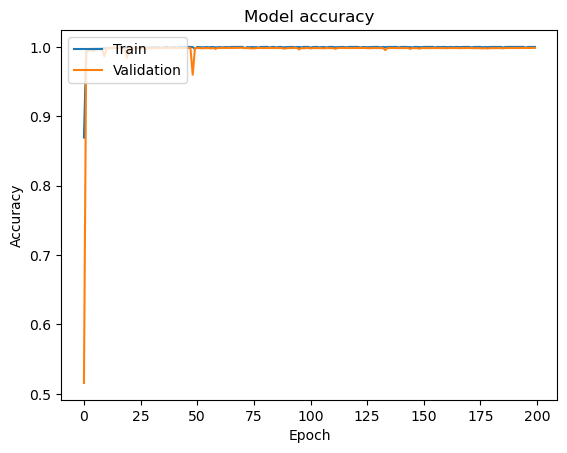

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


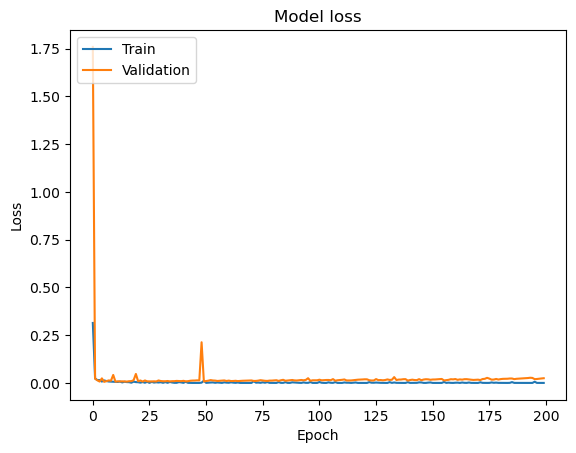

In [20]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()